# Генеративно-состязательные сети на примере рост-вес

In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Height: в 1 дюйме 2,54 см
# Weight: в 1 фунте 0,453 кг

In [2]:
dataset = pd.read_csv("weight-height.csv") 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  10000 non-null  float64
 1   Weight  10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


In [3]:
X_1 = dataset.iloc[:, 0].values
X_2 = dataset.iloc[:, 1].values
X = np.column_stack((X_1, X_2)) 
print(X)

[[ 73.84701702 241.89356318]
 [ 68.78190405 162.31047252]
 [ 74.11010539 212.74085556]
 ...
 [ 63.86799221 128.47531878]
 [ 69.03424313 163.85246135]
 [ 61.94424588 113.64910268]]


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)
print(X_train)

[[ 59.36813918 118.76451826]
 [ 63.91657834 156.77858596]
 [ 73.07534485 211.11480969]
 ...
 [ 67.46708591 162.47595732]
 [ 62.12748011 136.78302236]
 [ 70.59702452 188.45067415]]


In [5]:
torch.manual_seed(100)

In [6]:
train_data_length = 8000
train_labels = torch.zeros(train_data_length)
train_data = torch.from_numpy(X_train).type(torch.FloatTensor)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

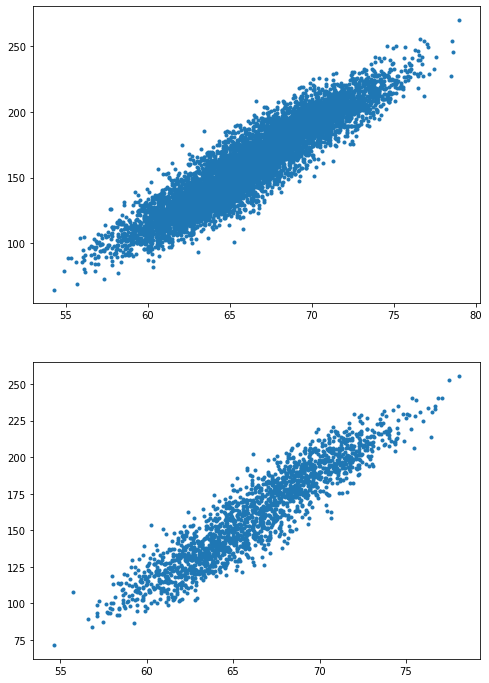

In [7]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.plot(X_train[:, 0], X_train[:, 1], ".")
plt.subplot(2, 1, 2)
plt.plot(X_test[:, 0], X_test[:, 1], ".")

In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator()
generator = Generator()

In [11]:
lr = 0.001
num_epochs = 125
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [12]:
for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 25 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.1356617510318756
Epoch: 0 Loss G.: 2.125305414199829


 20%|██        | 25/125 [00:27<01:51,  1.11s/it]

Epoch: 25 Loss D.: 0.6910815834999084
Epoch: 25 Loss G.: 0.683591365814209


 40%|████      | 50/125 [00:50<01:00,  1.23it/s]

Epoch: 50 Loss D.: 0.6933167576789856
Epoch: 50 Loss G.: 0.6897085905075073


 60%|██████    | 75/125 [01:13<00:47,  1.04it/s]

Epoch: 75 Loss D.: 0.6948074102401733
Epoch: 75 Loss G.: 0.6958408355712891


 80%|████████  | 100/125 [01:37<00:27,  1.11s/it]

Epoch: 100 Loss D.: 0.6929600238800049
Epoch: 100 Loss G.: 0.692771852016449


100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


### Вывод графиков для сравнения показателей

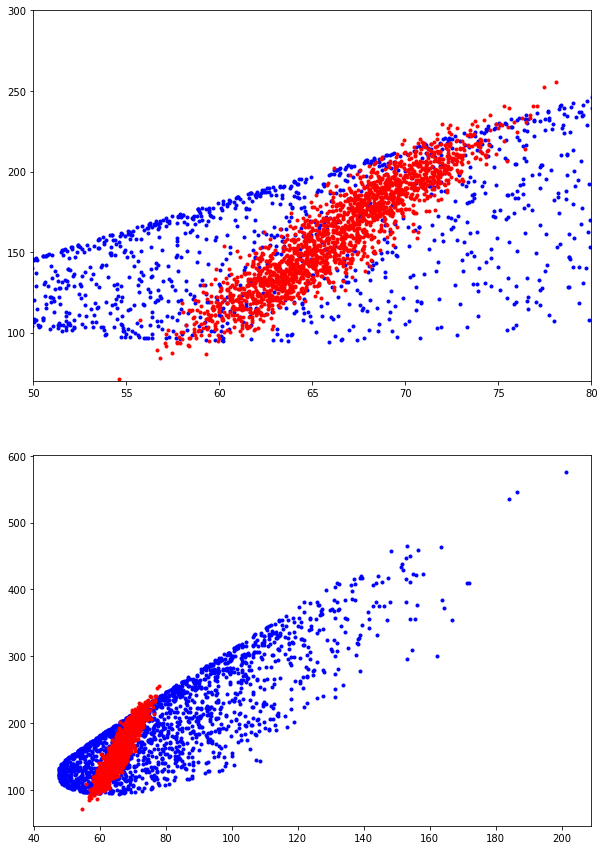

In [38]:
latent_space_samples = torch.randn(2000, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

plt.figure(figsize=(10, 15))

plt.subplot(2, 1, 1)
plt.xlim(50, 80)
plt.ylim(70, 300)
plt.plot(generated_samples[:, 0], generated_samples[:, 1], "b.",
        X_test[:, 0], X_test[:, 1], "r.")

plt.subplot(2, 1, 2)
plt.plot(generated_samples[:, 0], generated_samples[:, 1], "b.",
         X_test[:, 0], X_test[:, 1], "r.")